# CONSTANTS

In [24]:
EPOCHS = 171
LEARNING_RATE = 0.01
MANUAL_SEED = 12345
HIDDEN_NODE_COUNT = 64
DATASPLIT = 150
BATCH_SIZE = 64

OPTIMIZER="Adam"
ACTIVATION_FUNC = "ReLU"
WEIGHT_INIT = "Default"
LOSS_FUNC = "CEntropy"
POOLING_ALGO = "G. Mean"
NEURON_COUNT = "7, 3*64, 2"
NUM_GCN_LAYERS = "3"

In [25]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\andwh\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning:

pylab import has clobbered these variables: ['datetime', 'title']
`%matplotlib` prevents importing * from pylab and numpy



# DATASET IMPORT

In [26]:
from visualize import GraphVisualization
from networkx.algorithms import community
import networkx as nx
import plotly
import os
import torch

import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader

%run visualize.py


dataset = TUDataset(root='dataset/Mutag', name='MUTAG')


<Figure size 640x480 with 0 Axes>

In [27]:
data_details = {
    "num_node_features": dataset.num_node_features,
    "num_edge_features": dataset.num_edge_features,
    "num_classes": dataset.num_classes,
    "num_node_labels": dataset.num_node_labels,
    "num_edge_labels": dataset.num_edge_labels,
}

print(data_details)



{'num_node_features': 7, 'num_edge_features': 4, 'num_classes': 2, 'num_node_labels': 7, 'num_edge_labels': 4}


# VISUALIZATION

In [28]:
def create_graph(graph):
    g = to_networkx(graph)
    pos = nx.spring_layout(g)
    vis = GraphVisualization(
        g,
        pos,
        node_text_position="top left",
        node_size=20,
    )
    fig = vis.create_figure()
    return fig


fig = create_graph(dataset[0])
fig.show()


In [29]:
torch.manual_seed(MANUAL_SEED)


# Defining the loaders
dataset = dataset.shuffle()


# Allocate N to train
train_dataset = dataset[:DATASPLIT]
# Allocate the remainder to test
test_dataset = dataset[DATASPLIT:]



train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# MODEL

In [30]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_rate, in_features=7, outfeatures = 2):
        super(GCN, self).__init__()
        self.dropout_rate = dropout_rate

        # Input layer
        self.conv1 = GCNConv(in_features, hidden_channels)

        # Hidden layers
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)

        # Output layer
        self.lin = Linear(hidden_channels, outfeatures)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.lin(x)

        return x


# Set a manual seed andiinstantiate the model
model = GCN(hidden_channels=64, dropout_rate=0.5)

# PLOTTING FUNCTIONS

In [31]:
import sklearn
from sklearn.metrics import RocCurveDisplay, auc, precision_recall_curve
import numpy as np

from sklearn import metrics


# ROC AUC PLOT
def plotROCAUC(labels, probability_estimates, title, ax):
    # roc_auc = roc_auc_score(labels, predicted_labels)
    print(probability_estimates)

    fpr, tpr, _ = metrics.roc_curve(labels,  probability_estimates)
    auc = metrics.roc_auc_score(labels, probability_estimates)
    ax.set_title(title)
    ax.plot(fpr,tpr)
    ax.legend(["auc="+str(round(auc, 2))], handlelength=0, handletextpad=0)


    
    #RocCurveDisplay.from_predictions(labels, scores)


    #plt.show()

# ACCURACY PLOT
def plotAccuracy(losses, accuracies, title, ax):
    #fig, ax[0,1] = sub
    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.plot(losses)
    ax.plot(accuracies)
    ax.plot(losses, label="Loss")
    ax.plot(accuracies, label="Accuracy")
    ax.legend(loc="lower center")
    
    
    #plt.show()

#def plotPRAUC(labels, scores, title):

def plotPRAUC(labels, probability_estimates, predicted_labels, title, ax):
    # roc_auc = roc_auc_score(labels, probability_estimates)
    precision, recall, _ = precision_recall_curve(labels, probability_estimates)
    pr_auc = auc(recall, precision)

    #plt.figure(figsize=(8, 6))
    ax.step(recall, precision, color='b', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.2, color='b')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    #ax.set_title('Precision-Recall Curve (PR AUC = {:.2f})'.format(pr_auc))
    ax.legend(["prauc="+str(round(pr_auc, 2))], handlelength=0, handletextpad=0)
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    #plt.grid(True)
    #plt.show()



# TRAINING AND TEST FUNCTIONS

In [32]:

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = torch.nn.CrossEntropyLoss()

train_probability_estimates, train_losses, train_accuracies = [], [], []
train_labels, train_predicted_labels = [], []


def train(t):
    model.train()
    epoch_loss, epoch_accuracy = 0, 0

    for data in train_loader:  # Iterates the batches. We declared each batch to be of size 64

        # Calculate output, and get the maximum of those in order to obtain the predicted value
        out = model(data.x, data.edge_index, data.batch)
        cat = torch.argmax(out, dim=1)

        accuracy = (cat == data.y).float().mean()
        epoch_accuracy += accuracy.item()

        loss = loss_function(out, data.y)
        epoch_loss += loss.item()

        t.set_description("loss: %2f. accuracy %2f." % (loss, accuracy))


        # Append actual and preddicted to respective array. Have to be converted to NumPy arrays in order to flatten them.
        # We flatten them as 1D arrays are required by SK in order to calculate and plot ROC AUC
        arrayLabel = np.array(data.y)
        for value in arrayLabel.flatten():
            train_labels.append(value)
        

        arrayCat = np.array(cat)
        for value in arrayCat.flatten():
            train_predicted_labels.append(value)

        # Turn output tensor into numpy array
        arrayPred = out.detach().cpu().numpy()
        for index, value in enumerate(arrayPred):
            # We index into each array in arrayPred (2d array with 2 values)
            # Each value in array pred (ex.): [0.32, 0.95]. There are x of these, where x is batch size.
            # We index into each and obtain the predicted value depending on what the actual value (data.y) is for the corresponding index.
            #train_probability_estimates.append(value[data.y[index]])

            # It's more typical to collect the probability estimate for the positive class (or class 1) directly from the model's output.
            train_probability_estimates.append(value[1])

            #print("Label: {}. Two predicted values: {}. Chosen predicted value: {}".format(data.y[index], value, value[data.y[index]]))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # Calculate average loss and accuracy for the entire epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    avg_epoch_accuracy = epoch_accuracy / len(train_loader)

    train_losses.append(avg_epoch_loss)
    train_accuracies.append(avg_epoch_accuracy)



test_losses, test_accuracies = [], []
test_labels, test_predicted_labels, test_probability_estimates = [], [], []



def test(loader):
    model.eval()
    epoch_loss, epoch_accuracy = 0, 0

    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        cat = torch.argmax(out, dim=1)

        accuracy = (cat == data.y).float().mean()
        epoch_accuracy += accuracy.item()

        loss = loss_function(out, data.y)
        epoch_loss += loss.item()
        
        arrayLabel = np.array(data.y)
        for value in arrayLabel.flatten():
            test_labels.append(value)

        arrayCat = np.array(cat)
        for value in arrayCat.flatten():
            test_predicted_labels.append(value)

        # Turn output tensor into numpy array
        arrayPred = out.detach().cpu().numpy()
        for index, value in enumerate(arrayPred):
            # We index into each array in arrayPred (2d array with 2 values)
            # Each value in array pred (ex.): [0.32, 0.95]. There are x of these, where x is batch size.
            # We index into each and obtain the predicted value depending on what the actual value (data.y) is for the corresponding index.
            #test_probability_estimates.append(value[data.y[index]])
            test_probability_estimates.append(value[1])

    # Calculate average loss and accuracy for the entire epoch
    avg_epoch_loss = epoch_loss / len(loader)
    avg_epoch_accuracy = epoch_accuracy / len(loader)

    test_losses.append(avg_epoch_loss)
    test_accuracies.append(avg_epoch_accuracy)





# EXECUTION

loss: 0.248181. accuracy 1.000000.: 100%|██████████| 170/170 [00:07<00:00, 22.24it/s]


[-0.049792882, -0.041915514, -0.016889893, -0.026090799, -0.02550692, -0.03849839, -0.04167413, -0.033563133, -0.059107076, -0.03217251, -0.012551546, -0.024473779, -0.03820006, -0.019393973, -0.027898818, -0.044516593, -0.025566218, -0.020688284, -0.04576479, -0.037310638, -0.024025813, -0.04412834, -0.033945467, -0.040729403, -0.021285893, -0.02091549, -0.024213217, -0.025627345, -0.05916185, -0.031630427, -0.05384568, -0.050940763, -0.04785539, -0.028116807, -0.060725957, -0.009578165, -0.05438562, -0.033022724, -0.04893118, -0.072398245, -0.036216777, -0.024588093, -0.021134026, -0.050572813, -0.010370776, -0.039466765, -0.03807968, -0.03235922, -0.058541037, -0.06723285, -0.02382567, -0.047517873, -0.042876318, -0.053266272, -0.048959825, -0.043458156, -0.02654548, -0.047535196, -0.02829638, -0.02416435, -0.057110094, -0.025938751, -0.062011085, -0.039286166, 0.046558, 0.013528176, 0.07622555, 0.08095772, 0.019770376, 0.059309714, 0.029874176, 0.12603271, 0.029655464, 0.07365226, 

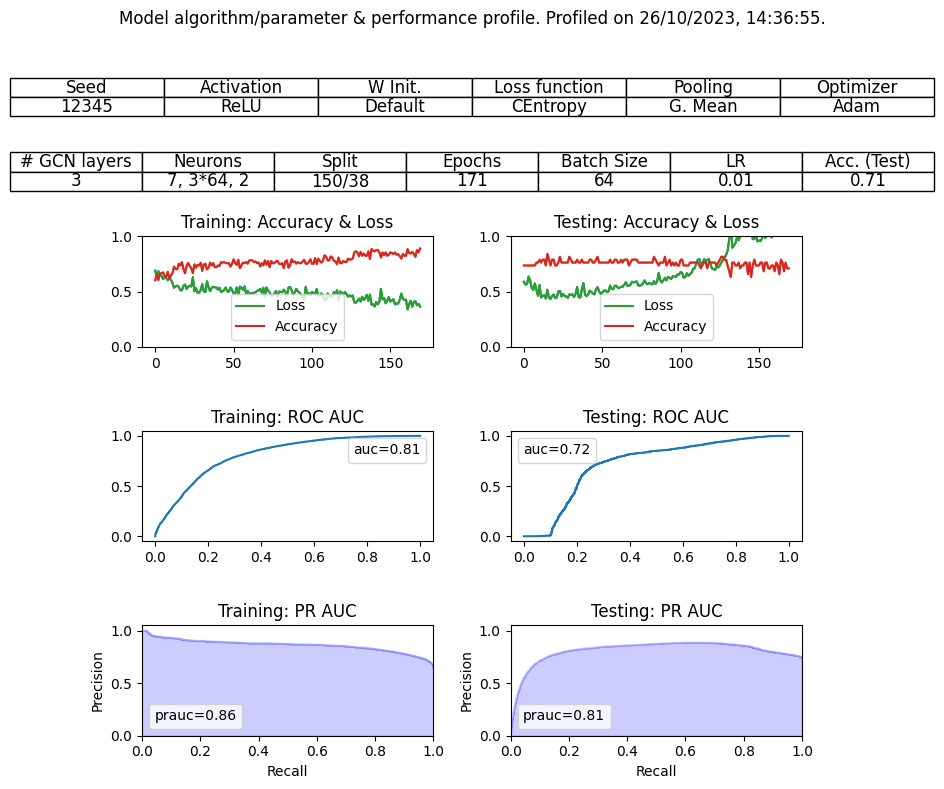

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc, f1_score, precision_recall_curve
from tqdm import trange
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from datetime import datetime

for epoch in (t := trange(1, EPOCHS)):
    train(t)
    test(test_loader)
    

# Flags
plot_training = True
plot_testing = True

plot_accuracy = True
plot_rocauc = True
plot_prauc = True

fig = plt.figure(figsize=(10, 8))

gs = gridspec.GridSpec(4, 2)

ax1 = plt.subplot(gs[0, :])

table_data = [
    ["Seed", "Activation", "W Init.", "Loss function", "Pooling", "Optimizer", "# GCN layers", "Neurons", "Split", "Epochs", "Batch Size", "LR", "Acc. (Test)"],
        [str(MANUAL_SEED), ACTIVATION_FUNC, WEIGHT_INIT, LOSS_FUNC, POOLING_ALGO, OPTIMIZER, NUM_GCN_LAYERS, NEURON_COUNT, "{}/{}".format(DATASPLIT, 188-DATASPLIT), str(EPOCHS), BATCH_SIZE, str(LEARNING_RATE), str(round(test_accuracies[-1], 2))],
]

table_data_1 = [table_data[0][:len(table_data[0]) // 2], table_data[1][:len(table_data[1]) // 2]]
table_data_2 = [table_data[0][len(table_data[0]) // 2:], table_data[1][len(table_data[1]) // 2:]]

# Create the first table in the top subplot (upper section)
table_1 = ax1.table(cellText=table_data_1, cellLoc='center', loc='center')
table_1.auto_set_font_size(False)
table_1.set_fontsize(12)
table_1.scale(1.4, 1.4)

# Create the second table in the top subplot (lower section)
table_2 = ax1.table(cellText=table_data_2, cellLoc='center', loc='bottom')
table_2.auto_set_font_size(False)
table_2.set_fontsize(12)
table_2.scale(1.4, 1.4)



# Hide axis and display the table
#ax1 = plt.gca()
ax1.axis('off')

#divider_y = -1.1  # Adjust the y-coordinate as needed
#ax1.axhline(divider_y, color='black')


#precision, recall, thresholds = precision_recall_curve(train_labels, probs)


# Plot for train
if(plot_training):
    if(plot_accuracy):
        #ax00 = ax[0, 0]
        ax00 = plt.subplot(gs[1, 0])

        plotAccuracy(train_losses, train_accuracies, "Training: Accuracy & Loss", ax00)

    if(plot_rocauc):
        #ax10 = ax[0, 1]
        ax10 = plt.subplot(gs[2, 0])

        plotROCAUC(labels=train_labels,  probability_estimates=train_probability_estimates, title="Training: ROC AUC", ax=ax10)

    if(plot_prauc):
        #ax20, row 2, column 0
        ax20 = plt.subplot(gs[3, 0])
        plotPRAUC(labels=train_labels, probability_estimates=train_probability_estimates, predicted_labels=train_predicted_labels, ax=ax20, title="Training: PR AUC")
    


# Plot for test
if(plot_testing):
    if(plot_accuracy):
        #ax01 = ax[1, 0]
        ax01 = plt.subplot(gs[1, 1])
        plotAccuracy(test_losses, test_accuracies, "Testing: Accuracy & Loss", ax01)

    if(plot_rocauc):
        #ax11 = ax[1, 1]
        ax11 = plt.subplot(gs[2, 1])

        plotROCAUC(labels=test_labels, probability_estimates=test_probability_estimates, title="Testing: ROC AUC" ,ax=ax11)
    
    if(plot_prauc):
        #ax20, row 2, column 0
        ax21 = plt.subplot(gs[3, 1])
        plotPRAUC(labels=test_labels, probability_estimates=test_probability_estimates, predicted_labels=test_predicted_labels, ax=ax21, title="Testing: PR AUC")
    

now = datetime.now()

title = "Model algorithm/parameter & performance profile. Profiled on {}.".format(now.strftime("%d/%m/%Y, %H:%M:%S"))

fig.suptitle(title, fontsize=12, wrap=True)

plt.tight_layout()


print("Lengths:")
print(len(train_predicted_labels))
print(len(train_probability_estimates))

print("perf measure:")






#plotPRAUC(test_labels, test_probability_estimates, test_predicted_labels, "PR AUC")



In [34]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid


from sklearn.model_selection import train_test_split

# Extract the features (X) and labels (y)


# Split the dataset into training and testing sets
#train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#param_grid = dict(hidden_channels=[32,64])
param_grid = {
    'dropout_rate': [0.25, 0.5, 0.75],
    'hidden_channels': [32, 64],
}

# Initialize variables to keep track of the best model and its accuracy
best_model = None
best_epoch_accuracy = 0.0
best_params = None

#print(ParameterGrid(param_grid))
#for data in ParameterGrid(param_grid):
#   print(data)

for params in ParameterGrid(param_grid):
    print(params)

for params in ParameterGrid(param_grid):
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    epoch_accuracy_for_configuration = 0
    #model = GCN(**params)
    model = GCN(hidden_channels=params["hidden_channels"], dropout_rate=params["dropout_rate"])
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_function = torch.nn.CrossEntropyLoss()

    test_accuracies_grid = []

    for epoch in range(EPOCHS):
        # TRAIN
        model.train()
        #epoch_loss, epoch_accuracy = 0, 0

        for data in train_loader:  # Iterates the batches. We declared each batch to be of size 64

            # Calculate output, and get the maximum of those in order to obtain the predicted value
            out = model(data.x, data.edge_index, data.batch)
            cat = torch.argmax(out, dim=1)

            accuracy = (cat == data.y).float().mean()
            #epoch_accuracy += accuracy.item()

            loss = loss_function(out, data.y)
            #epoch_loss += loss.item()

            t.set_description("loss: %2f. accuracy %2f." % (loss, accuracy))


            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        #avg_epoch_loss = epoch_loss / len(train_loader)
        #avg_epoch_accuracy = epoch_accuracy / len(train_loader)

        #train_losses.append(avg_epoch_loss)
        #train_accuracies.append(avg_epoch_accuracy)

        # EVAL
        model.eval()
        epoch_loss, epoch_accuracy = 0, 0

        for data in test_loader:  # Iterate in batches over the training/test dataset.
            out = model(data.x, data.edge_index, data.batch)
            cat = torch.argmax(out, dim=1)

            accuracy = (cat == data.y).float().mean()
            epoch_accuracy += accuracy.item()

            loss = loss_function(out, data.y)
            epoch_loss += loss.item()

        
            
           

           

        # Calculate average loss and accuracy for the entire epoch
        avg_epoch_loss = epoch_loss / len(test_loader)
        avg_epoch_accuracy = epoch_accuracy / len(test_loader)
        test_accuracies_grid.append(avg_epoch_accuracy)


        #test_losses.append(avg_epoch_loss)
        #test_accuracies.append(avg_epoch_accuracy)
    


    #model.eval()
    #with torch.no_grad():
    #    y_pred = model(X_test)
    #accuracy = accuracy_score(y_test, y_pred)

    #epoch_accuracy_for_configuration = test_accuracies[-1]
    print("Parameter configuration results:\n Configuration: {}\n Accuracy: {}.\n".format(params, test_accuracies_grid[-1]))
    if test_accuracies_grid[-1] > best_epoch_accuracy:
        best_epoch_accuracy = test_accuracies_grid[-1]
        best_model = model
        best_params = params

    test_accuracies.clear

        

        #if avg_epoch_accuracy > best_epoch_accuracy_for_configuration:
            #best_epoch_accuracy_for_configuration = avg_epoch_accuracy


    model = None
            

                
    


print("Best accuracy: {}.\n Model used: {}.\n With parameter configuration: {}".format(best_epoch_accuracy, best_model, best_params))




{'dropout_rate': 0.25, 'hidden_channels': 32}
{'dropout_rate': 0.25, 'hidden_channels': 64}
{'dropout_rate': 0.5, 'hidden_channels': 32}
{'dropout_rate': 0.5, 'hidden_channels': 64}
Parameter configuration results:
 Configuration: {'dropout_rate': 0.25, 'hidden_channels': 32}
 Accuracy: 0.7631579041481018.

Parameter configuration results:
 Configuration: {'dropout_rate': 0.25, 'hidden_channels': 64}
 Accuracy: 0.7105262875556946.

Parameter configuration results:
 Configuration: {'dropout_rate': 0.5, 'hidden_channels': 32}
 Accuracy: 0.7105262875556946.

Parameter configuration results:
 Configuration: {'dropout_rate': 0.5, 'hidden_channels': 64}
 Accuracy: 0.7105262875556946.

Best accuracy: 0.7631579041481018.
 Model used: GCN(
  (conv1): GCNConv(7, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (conv4): GCNConv(32, 32)
  (conv5): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
).
 With parameter configuration: {'dropout_rate': 0.25, 'hidden_c

In [35]:
""" #https://scikit-learn.org/stable/modules/grid_search.html
# By far, the most common optimization algorithm is plain old Stochastic Gradient Descent (SGD) because it is so well understood. 
# In this example, you will look at optimizing the SGD learning rate and momentum parameters.
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


param_grid = dict(hidden_channels=[32,64])
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
#grid_result = grid.fit(X, Y)

X_train, X_test, y_train, y_test = train_test_split(dataset, dataset.data.y, test_size=0.2, random_state=42)

best_model = grid_search.best_estimator_
y_pred = best_model(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {accuracy:.4f}') """


#https://github.com/pyg-team/pytorch_geometric/issues/240

" #https://scikit-learn.org/stable/modules/grid_search.html\n# By far, the most common optimization algorithm is plain old Stochastic Gradient Descent (SGD) because it is so well understood. \n# In this example, you will look at optimizing the SGD learning rate and momentum parameters.\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.model_selection import train_test_split\n\n\nparam_grid = dict(hidden_channels=[32,64])\ngrid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')\n#grid_result = grid.fit(X, Y)\n\nX_train, X_test, y_train, y_test = train_test_split(dataset, dataset.data.y, test_size=0.2, random_state=42)\n\nbest_model = grid_search.best_estimator_\ny_pred = best_model(X_test)\naccuracy = accuracy_score(y_test, y_pred)\nprint(f'Accuracy on test set: {accuracy:.4f}') "